In [ ]:
import os
import cv2
import pandas
import random
import string

import keras
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# removing the data rows where 'IDENTITY' is 'UNREADABLE'
def cleaningData(data_csv):
    initial_size = data_csv.shape[0]
    data_csv = data_csv[data_csv["IDENTITY"] != "UNREADABLE"]

    print(f"data_csv size: {initial_size} --> {data_csv.shape[0]}")

    return data_csv

In [3]:
# ---------------------- loading the data ----------------------
train_csv = pandas.read_csv("data/written_name_train_v2.csv")
valid_csv = pandas.read_csv("data/written_name_validation_v2.csv")

train_images_dir_path = "data/train_v2/train"
valid_images_dir_path = "data/validation_v2/validation"

# ---------------------- cleaning the data ----------------------
train_csv = cleaningData(train_csv)
valid_csv = cleaningData(valid_csv)

# ---------------------- visualizing the data ----------------------
print(train_csv.shape[0], valid_csv.shape[0])
train_csv.head(5)

data_csv size: 330961 --> 330859
data_csv size: 41370 --> 41358
330859 41358


,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


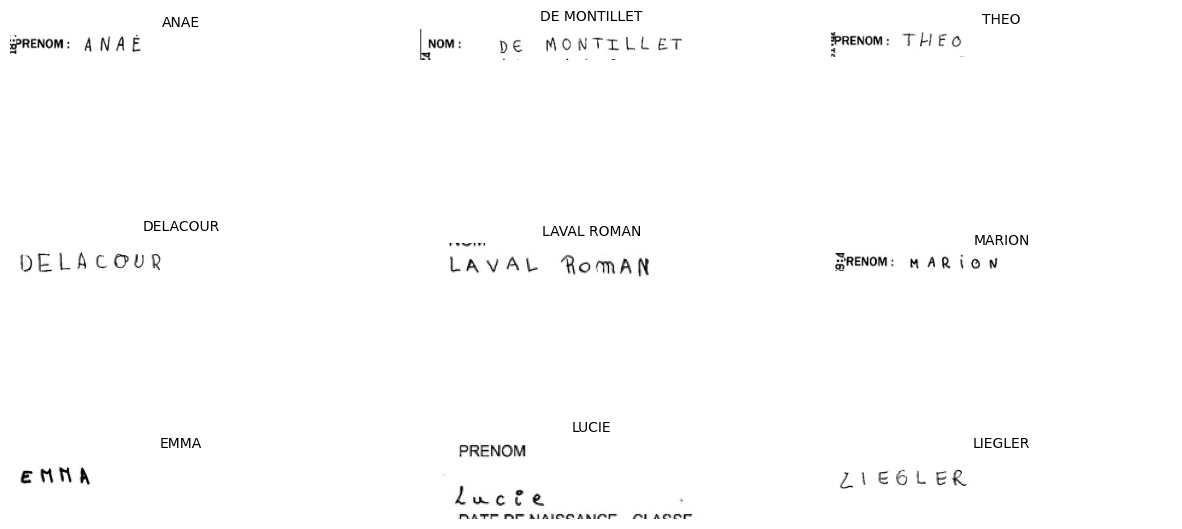

In [4]:
def dataVisualization(data_csv, image_dir_path):
    figure, axes = plt.subplots(3, 3, figsize=(15, 8))

    for i in range(9):
        row = i // 3
        col = i % 3

        index = random.randint(1, 1000)

        image_path = os.path.join(image_dir_path, data_csv.loc[index, "FILENAME"])
        image = cv2.imread(image_path, 0)

        axes[row, col].imshow(image, cmap="gray")
        axes[row, col].set_title(data_csv.loc[index, "IDENTITY"], fontsize=10)
        axes[row, col].axis("off")

    plt.show()

dataVisualization(train_csv, train_images_dir_path)

In [5]:
# preprocessing the data
alphabets = string.ascii_uppercase + "' -"
max_str_len = 24
num_of_chars = len(alphabets) + 1
num_of_timestamps = 64
batch_size = 512

def encode2label(text):
    list = []
    for char in str(text):
        index = alphabets.find(char)
        list.append(index if index != -1 else alphabets.find('-'))

    return keras.utils.pad_sequences([list], maxlen=max_str_len, padding="post", value=-1)[0]

def decode2text(array):
    text = ""
    for number in array:
        if number == -1:
            break
        else:
            text += alphabets[number]

    return text

# ---------------------- testing the encoding / decoding ----------------------
print(encode2label("VLAD TOMICI"))
print(decode2text([21, 11,  0,  3, 27, 19, 14, 12,  8,  2,  8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]))

[21 11  0  3 27 19 14 12  8  2  8 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
VLAD TOMICI


In [6]:
@tf.function
def preprocessImage(image_path, label, label_len):
    file = tf.io.read_file(image_path)

    image = tf.image.decode_png(file, channels=1)

    image = tf.image.convert_image_dtype(image, tf.float32)

    image = tf.image.resize(image, [64, 256])

    input_len = [num_of_timestamps - 2]

    return image, label, input_len, label_len, [0]

def createDataList(data_csv, image_dir_path):
    data_x, data_y, label_len = [], [], []

    for index, row in data_csv.iterrows():
        if isinstance(row["IDENTITY"], str):
            data_x.append(os.path.join(image_dir_path, row["FILENAME"]))
            data_y.append(encode2label(row["IDENTITY"].upper()))
            label_len.append(len(row["IDENTITY"]))

    return data_x, data_y, label_len

def createTFDataset(data_x, data_y, label_len):
    dataset = tf.data.Dataset.from_tensor_slices((data_x, data_y, label_len))
    dataset = dataset.map(preprocessImage, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)

    dataset = dataset.map(lambda *x: (x[0:-1], x[-1]))\
        .prefetch(tf.data.experimental.AUTOTUNE)\
        .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [7]:
# ---------- creating TF dataset for training data ----------
train_x, train_y, train_label_len = createDataList(train_csv, train_images_dir_path)
train_dataset = createTFDataset(train_x, train_y, train_label_len)

# ---------- creating TF dataset for validation data ----------
valid_x, valid_y, valid_label_len = createDataList(valid_csv, valid_images_dir_path)
valid_dataset = createTFDataset(valid_x, valid_y, valid_label_len)

KeyboardInterrupt: 

In [ ]:
def ctcLambdaFunc(arguments):
    y_pred, labels, input_length, label_length = arguments

    return keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

def convBlock(num_filters, use_max_pool=True, pool_size=(4, 2), stride=2):
    cnn = keras.Sequential()
    cnn.add(
        keras.layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same"))
    cnn.add(
        keras.layers.BatchNormalization())
    cnn.add(
        keras.layers.MaxPool2D(pool_size=pool_size, strides=stride))

    return cnn

def CRNN():
    inputs = keras.layers.Input(name="image", shape=(64, 256, 1))
    labels = keras.layers.Input(name="label", shape=(None, ), dtype="float32")

    input_length = keras.layers.Input(name="input_length", shape=[1], dtype="int64")
    label_length = keras.layers.Input(name="label_length", shape=[1], dtype="int64")

    # ---------- CNN ----------
    conv1 = convBlock(32)(inputs)
    conv2 = convBlock(64)(conv1)
    conv3 = convBlock(128, pool_size=(4, 1), stride=1)(conv2)
    conv4 = convBlock(256, pool_size=(4, 1), stride=1)(conv3)
    conv5 = convBlock(128, pool_size=(5, 1), stride=1)(conv4)

    # ---------- CNN --> RNN ----------
    reshape = keras.layers.Reshape((num_of_timestamps, 512))(conv5)
    dense = keras.layers.Dense(num_of_timestamps, activation="relu")(reshape)
    batchNormalization = keras.layers.BatchNormalization()(dense)
    dropout = keras.layers.Dropout(0.2)(batchNormalization)

    # ---------- RNN ----------
    lstm1 = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.2)
    )(dropout)
    lstm2 = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.2)
    )(lstm1)

    # ---------- outputs ----------
    y_pred = keras.layers.Dense(num_of_chars, activation="softmax")(lstm2)
    ctc_loss = keras.layers.Lambda(ctcLambdaFunc, output_shape=(1, ), name="ctc")([y_pred, labels, input_length, label_length])

    pred_model = keras.models.Model(inputs=inputs, outputs=y_pred)
    train_model = keras.models.Model(inputs=[inputs, labels, input_length, label_length], outputs=ctc_loss)

    return pred_model, train_model

model, train_model = CRNN()

train_model.summary()

In [ ]:
# ---------- training the model ----------
train_model.compile(
    loss = {"ctc": lambda y_true, y_pred: y_pred},
    optimizer = keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        clipnorm=1.0)
)

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="best_model.h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="auto"
)

earlyStopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="auto",
    patience=10
)

history = train_model.fit(
    train_dataset,
    epochs=30,
    validation_data = valid_dataset,
    verbose = 1,
    shuffle = True,
    callbacks = [checkpoint, earlyStopping]
)

model.save("model.h5")

In [1]:
# ---------- plotting the training process ----------
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("training loss vs validation loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

NameError: name 'plt' is not defined

In [1]:
model.load_weights("best_model.h5")

def ctcDecoder(predictions):

    predictions = []

    pred_indices = np.argmax(predictions, axis=2)

    for i in range(pred_indices.shape[0]):
        ans = ""

        merged_list = [k for k,_ in groupby(pred_indices[i])]

        for p in merged_list:
             if p != len(alphabets):
                 ans += alphabets[int(p)]

        predictions.append(ans)

    return predictions

def getPredictionsAndLabels(dataset, model):
    predictions, labels = [], []

    for batch in dataset.as_numpy_iterator():
        images, num_labels = batch[0][0], batch[0][1]

        preds = model.predict(images)
        predictions.extend(ctcDecoder(preds))

        labels.extend([decode2text(num_labels[i]) for i in range(len(num_labels))])

    return predictions, labels

predictions, labels = getPredictionsAndLabels(valid_dataset, model)

print(len(predictions), len(labels))

NameError: name 'model' is not defined

In [ ]:
def getAccuracyCharactersAndWord(predictions, labels):
    wordAccuracy